In [38]:
import sys

import numpy as np
import tensorflow as tf
from keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio
import cartopy.crs as ccrs

from scipy import signal

In [39]:

# Carica i file .mat
#data = sio.loadmat('U1_S1_M1load.mat')
#U1 = Utente 1
#U2 = Utente 2
#S1 = Strada 1 (dissestata)
#S2 = Strada 2 (liscia)
#M1 = Monopattino 1 (sano)
#M2 = Monopattino 2 (danneggiato)
inDataConstrainSize = 63000
Accelerations = np.zeros((2,2,2,inDataConstrainSize,4))

for u in range(1,3):
    for s in range(1,3):
        for m in range(1,3):
            fileName = 'U'+str(u) +'_S'+ str(s)+ '_M'+ str(m)+'load.mat'
            #print(name+' loaded')
            
            data = sio.loadmat(fileName)
            Acceleration = data['acceleration']
            
            print(fileName+' size: '+str(data['acceleration'].shape[0]))
            
            Accelerations[u-1,s-1,m-1,:,:] = Acceleration[:63000,:]

#print(data.keys())
#Acceleration = data['acceleration']
#print(data['acceleration'].shape)
#print(Acceleration[3])


U1_S1_M1load.mat size: 63948
U1_S1_M2load.mat size: 63123
U1_S2_M1load.mat size: 64681
U1_S2_M2load.mat size: 64007
U2_S1_M1load.mat size: 64620
U2_S1_M2load.mat size: 64577
U2_S2_M1load.mat size: 63102
U2_S2_M2load.mat size: 63660


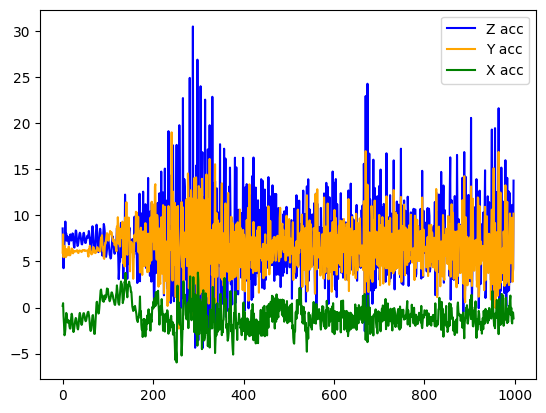

In [40]:

Acceleration = data['acceleration']
span = 499
current = 1
start = current * span
stop = (current+1) * span

#timestamp = np.squeeze(Acceleration[:stop,0])
acc_x = np.squeeze(Acceleration[:stop,1])
acc_y = np.squeeze(Acceleration[:stop,2])
acc_z = np.squeeze(Acceleration[:stop,3])


plt.plot( acc_z, label='Z acc', color='blue')
plt.plot( acc_y, label='Y acc', color='orange')
plt.plot( acc_x, label='X acc', color='green')
plt.legend()


c:\Users\Ciosep\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 998, using nperseg = 998
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


Text(0.5, 1.0, 'Z')

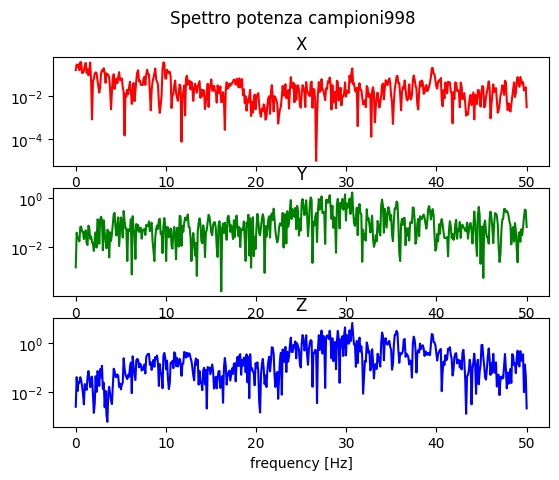

In [41]:
fs = 100
f, Pxacc = signal.welch(acc_x, fs, nperseg=1024)
f, Pyacc = signal.welch(acc_y, fs, nperseg=1024)
f, Pzacc = signal.welch(acc_z, fs, nperseg=1024)
'''
plt.semilogy(f, Pxacc, color = 'Red')
plt.semilogy(f, Pyacc, color = 'green')
plt.semilogy(f, Pzacc, color = 'blue')
'''
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Spettro potenza campioni'+str(stop))
ax1.semilogy(f, Pxacc, color = 'Red')
ax1.set_title('X')
plt.xlabel('frequency [Hz]')
ax2.semilogy(f, Pyacc, color = 'green')
ax2.set_title('Y')
ax3.semilogy(f, Pzacc, color = 'blue')
ax3.set_title('Z')


In [42]:
#creazione dataset di elaborazione
percentAcqTrain = 0.6 # %
nSamples = 256
fs = 100

#dataset di traing
trainData=[]
trainDataMeta=[]
nPackets = int(inDataConstrainSize/nSamples)

print('nPackets: '+str(nPackets))
print('dataset width:'+str(129*3))
for u in range(0,2):
	for i in range(0, int(nPackets*percentAcqTrain)):
		acqPower= []
		for j in range(3): # X Y Z
		
			acc = Accelerations[u, 1, 0, i*nSamples:nSamples*(i+1), j+1]
			f, Pacc = signal.welch(acc, fs, nperseg=256)   
			acqPower = np.append(acqPower, Pacc)

		trainDataMeta.append(acqPower)

trainData = np.stack(trainDataMeta, axis=0)

print(str(int(nPackets*percentAcqTrain))+'->'+str(int(nPackets*percentAcqTrain)*2))
print(trainData.shape)

##dataset di test
percentAcqTest=1-percentAcqTrain
testDataNormal =[]
testDataNormalMeta =[]


for u in range(2):
	for i in range(int(nPackets*percentAcqTrain), nPackets):
		acqPower= []
		for j in range(3): # X Y Z
			acc = Accelerations[u, 1, 0, i*nSamples:nSamples*(i+1), j+1]
			f, Pacc = signal.welch(acc, fs, nperseg=256)   
			acqPower = np.append(acqPower, Pacc)
		
		testDataNormalMeta.append(acqPower)

testDataNormal = np.stack(testDataNormalMeta)

print(str(int(nPackets*percentAcqTest))+'->'+str(int(nPackets*percentAcqTest)*2))
print(testDataNormal.shape)

#dataset anomalo
percentAcqAnom = 1
testDataAnomalies =[]
testDataAnomaliesMeta =[]

for u in range(2):
	for i in range(0,int(nPackets*percentAcqAnom)):
		acqPower= []
		for j in range(3): # X Y Z
			acc = Accelerations[u, 0, 0, i*nSamples:nSamples*(i+1), j+1]
			f, Pacc = signal.welch(acc, fs, nperseg=256)   
			acqPower = np.append(acqPower, Pacc)
		
		testDataAnomaliesMeta.append(acqPower)

testDataAnomalies = np.stack(testDataAnomaliesMeta)
print(str(int(nPackets*percentAcqAnom))+'->'+str(int(nPackets*percentAcqAnom)*2))
print(testDataAnomalies.shape)



nPackets: 246
dataset width:387
147->294
(294, 387)
98->196
(198, 387)
246->492
(492, 387)


In [43]:
#creazione dataset di test concatenando dati normali e anomali
testData = np.concatenate([testDataNormal, testDataAnomalies])

#etichette dati test
#(0 per normale, 1 per anomalia)
dataLabel = np.concatenate([np.zeros(len(testDataNormal)), np.ones(len(testDataAnomalies))])

# Normalizzare i dati
scaler = MinMaxScaler()
trainData_scaled = scaler.fit_transform(trainData)
testData_scaled = scaler.transform(testData)

In [44]:
# Costruzione dell'autoencoder
input_dim = trainData_scaled.shape[1]
encoding_dim = 5  # Dimensione del codice latente

autoencoder = models.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(encoding_dim, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(input_dim, activation="sigmoid")  # Output riconstruito
])
autoencoder.compile(optimizer='adam', loss='mse')

# Addestramento dell'autoencoder
history = autoencoder.fit(trainData_scaled, trainData_scaled, epochs=200, batch_size=32, validation_split=0.2, verbose=0)

# Funzione per calcolare l'errore di ricostruzione
def compute_reconstruction_error(X, model):
    X_pred = model.predict(X)
    mse = np.mean(np.power(X - X_pred, 2), axis=1)
    return mse

# Calcolare gli errori di ricostruzione su dati normali e anomali
train_error = compute_reconstruction_error(trainData_scaled, autoencoder)
test_error = compute_reconstruction_error(testData_scaled, autoencoder)

# Definire una soglia per il rilevamento delle anomalie (ad esempio, il 99° percentile dell'errore sui dati di training)
threshold = np.percentile(train_error, 99)

# Classificare le anomalie
test_predictions = (test_error > threshold).astype(int)



22/22 [==============================] - 0s 1ms/step


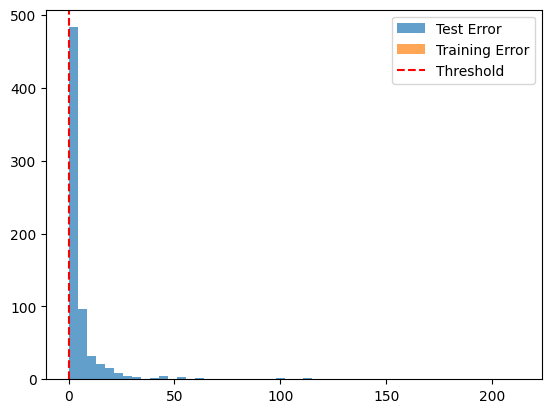

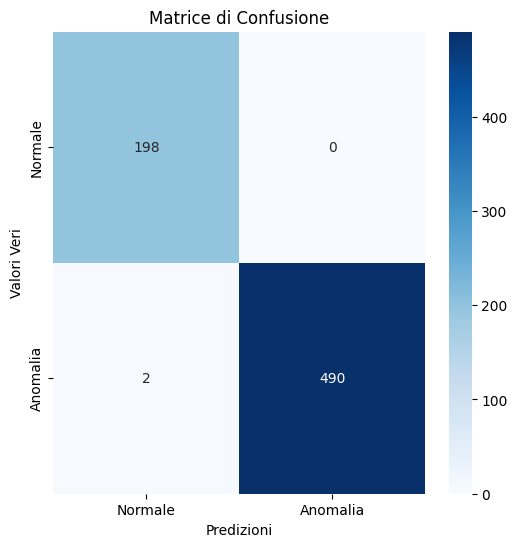

Accuratezza: 1.00
Precisione: 1.00
Recall: 1.00
F1-Score: 1.00


In [45]:
plt.figure()

# Visualizzare i risultati
plt.hist(test_error, bins=50, alpha=0.7, label='Test Error')
plt.hist(train_error, bins=50, alpha=0.7, label='Training Error')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()


# Visualizzare la matrice di confusione
conf_matrix = confusion_matrix(dataLabel, test_predictions)

# Plot della matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normale', 'Anomalia'], yticklabels=['Normale', 'Anomalia'])
plt.title('Matrice di Confusione')
plt.xlabel('Predizioni')
plt.ylabel('Valori Veri')
plt.show()

# Calcolare le metriche di valutazione
accuracy = accuracy_score(dataLabel, test_predictions)
precision = precision_score(dataLabel, test_predictions)
recall = recall_score(dataLabel, test_predictions)
f1 = f1_score(dataLabel, test_predictions)

print(f"Accuratezza: {accuracy:.2f}")
print(f"Precisione: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")